<a href="https://colab.research.google.com/github/damitkumar11/Diamonds-Prices-of-over-50-000-round-cut-diamonds/blob/main/Diamond_price_predict_CatBoost%2BSHAP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Diamonds /Prices of over 50,000 round cut diamonds

# About Dataset
Format
A data frame with 53940 rows and 10 variables:

price
price in US dollars ($326--$18,823)

carat
weight of the diamond (0.2--5.01)

cut
quality of the cut (Fair, Good, Very Good, Premium, Ideal)

color
diamond colour, from D (best) to J (worst)

clarity
a measurement of how clear the diamond is (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))

x
length in mm (0--10.74)

y
width in mm (0--58.9)

z
depth in mm (0--31.8)

depth
total depth percentage = z / mean(x, y) = 2 * z / (x + y) (43--79)

table
width of top of diamond relative to widest point (43--95)

**Importing libraries and loading data**

In [ ]:
!pip install -q feature_engine

In [ ]:
!pip install shap

In [ ]:
!pip install catboost

In [ ]:
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

import shap
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import Pool, CatBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from feature_engine.encoding import RareLabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
import re

pd.set_option('display.max_rows', 1000)

In [ ]:
df = pd.read_csv('/content/diamonds.csv').drop_duplicates()
print(df.shape)
df.sample(5).T

(53794, 10)


,21057,3121,34600,32901,11368
carat,0.31,0.7,0.27,0.36,1.04
cut,Ideal,Ideal,Very Good,Fair,Ideal
color,F,H,E,F,I
clarity,VS2,VVS2,VS1,VS1,VS1
depth,62.3,60.9,61.9,55.3,62.9
table,55.0,56.0,59.0,67.0,43.0
price,625,3325,470,810,4997
x,4.35,5.76,4.16,4.79,6.45
y,4.38,5.79,4.21,4.72,6.41
z,2.72,3.52,2.59,2.63,4.04


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53794 entries, 0 to 53939
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    53794 non-null  float64
 1   cut      53794 non-null  object 
 2   color    53794 non-null  object 
 3   clarity  53794 non-null  object 
 4   depth    53794 non-null  float64
 5   table    53794 non-null  float64
 6   price    53794 non-null  int64  
 7   x        53794 non-null  float64
 8   y        53794 non-null  float64
 9   z        53794 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 4.5+ MB


In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
carat,53794.0,0.797780,0.473390,0.2,0.40,0.70,1.04,5.01
depth,53794.0,61.748080,1.429909,43.0,61.00,61.80,62.50,79.00
table,53794.0,57.458109,2.233679,43.0,56.00,57.00,59.00,95.00
price,53794.0,3933.065082,3988.114460,326.0,951.00,2401.00,5326.75,18823.00
x,53794.0,5.731214,1.120695,0.0,4.71,5.70,6.54,10.74
y,53794.0,5.734653,1.141209,0.0,4.72,5.71,6.54,58.90
z,53794.0,3.538714,0.705037,0.0,2.91,3.53,4.03,31.80


**Data transformation**

In [ ]:
# select label
main_label = 'log10_price'
df[main_label] = df['price'].apply(lambda x: np.log10(x))
# log10-transform carat and group into larger bins
df['log10_carat'] = df['carat'].apply(lambda x: 1/50*round(50*np.log10(x)))
# exclude records with zero x, y, or z
df = df[df['x']>0]
df = df[df['y']>0]
df = df[df['z']>0]
# create log10mean from x and y
df['log10mean'] = (df['x'] + df['y']).apply(lambda x: 1/10*round(10*np.log10(0.5*x)))
# group depth and table into larger bins
df['depth'] = df['depth'].apply(lambda x: str(5*round(1/5*x)))
df['table'] = df['table'].apply(lambda x: str(5*round(1/5*x)))
# set up the rare label encoder limiting number of categories to max_n_categories
for col in ['cut', 'color', 'clarity', 'depth', 'table']:
    df[col] = df[col].fillna('None')
    encoder = RareLabelEncoder(n_categories=1, max_n_categories=60, replace_with='Other', tol=20.0/df.shape[0])
    df[col] = encoder.fit_transform(df[[col]])
# drop unused columns
cols2drop = ['price', 'carat', 'x', 'y', 'z']
df = df.drop(cols2drop, axis=1)
print(df.shape)
df.sample(5).T

(53775, 8)


,3170,46792,23697,18074,43184
cut,Fair,Premium,Very Good,Premium,Very Good
color,I,G,J,I,G
clarity,SI1,VVS2,SI1,SI1,SI1
depth,60,60,60,60,65
table,65,60,55,60,60
log10_price,3.523356,3.256718,4.070555,3.863442,3.143639
log10_carat,0.0,-0.3,0.32,0.22,-0.26
log10mean,0.8,0.7,0.9,0.9,0.7


**Machine learning**

In [ ]:
# initialize data
y = df[main_label].values.reshape(-1,)
X = df.drop([main_label], axis=1)
cat_cols = df.select_dtypes(include=['object']).columns
cat_cols_idx = [list(X.columns).index(c) for c in cat_cols]
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.5, random_state=0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((26887, 7), (26888, 7), (26887,), (26888,))

In [ ]:
# initialize Pool
train_pool = Pool(X_train,
                  y_train,
                  cat_features=cat_cols_idx)
test_pool = Pool(X_test,
                 y_test,
                 cat_features=cat_cols_idx)
# specify the training parameters
model = CatBoostRegressor(iterations=700,
                          depth=5,
                          verbose=0,
                          learning_rate=0.1,
                          loss_function='RMSE')
#train the model
model.fit(train_pool)
# make the prediction using the resulting model
y_train_pred = model.predict(train_pool)
y_test_pred = model.predict(test_pool)

rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)
print(f"RMSE score for train {round(rmse_train,3)} dex, and for test {round(rmse_test,3)} dex")

RMSE score for train 0.043 dex, and for test 0.044 dex


In [ ]:
# Baseline scores (assuming the same prediction for all data samples)
rmse_bs_train = mean_squared_error(y_train, [np.mean(y_train)]*len(y_train), squared=False)
rmse_bs_test = mean_squared_error(y_test, [np.mean(y_train)]*len(y_test), squared=False)
print(f"RMSE baseline score for train {round(rmse_bs_train,3)} dex, and for test {round(rmse_bs_test,3)} dex")

RMSE baseline score for train 0.439 dex, and for test 0.442 dex


**Explanations with SHAP values**

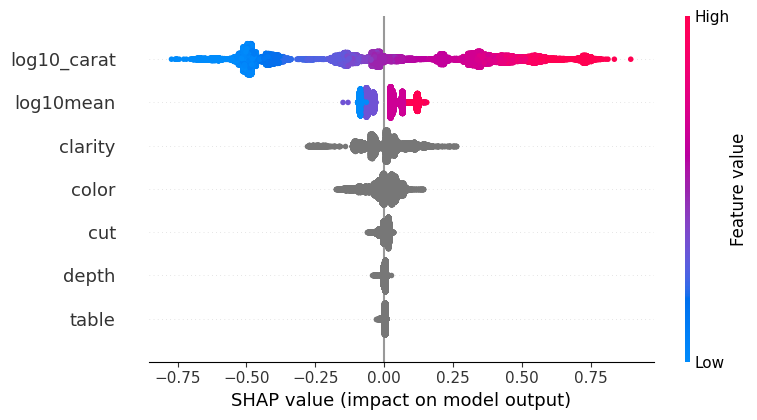

In [ ]:
shap.initjs()
ex = shap.TreeExplainer(model)
shap_values = ex.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

In [ ]:
expected_values = ex.expected_value
print(f"Average predicted price is {round(10**expected_values)} USD")
print(f"Average actual price is {round(10**np.mean(y_test))} USD")

Average predicted price is 2414 USD
Average actual price is 2403 USD



cut



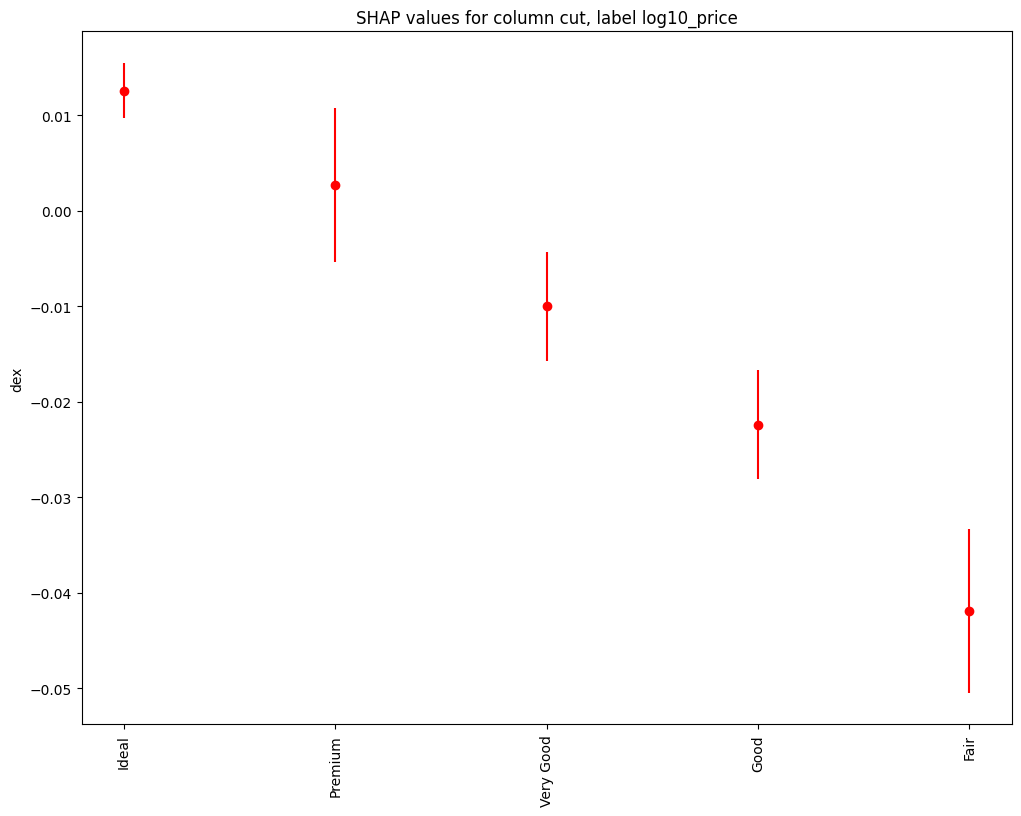

             gain  gain_std  count
col                               
Ideal      0.0126    0.0029  10731
Premium    0.0027    0.0081   6842
Very Good -0.0100    0.0057   6075
Good      -0.0224    0.0057   2407
Fair      -0.0419    0.0086    833

color



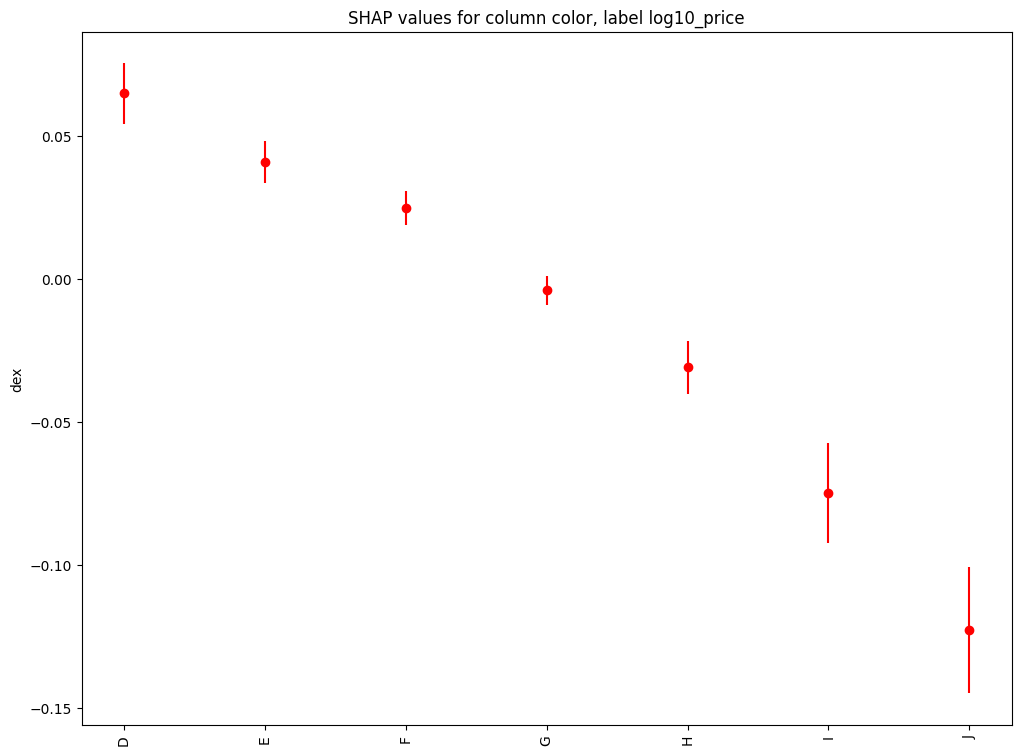

       gain  gain_std  count
col                         
D    0.0649    0.0106   3421
E    0.0410    0.0074   4887
F    0.0248    0.0061   4699
G   -0.0040    0.0052   5605
H   -0.0309    0.0092   4156
I   -0.0750    0.0175   2742
J   -0.1228    0.0220   1378

clarity



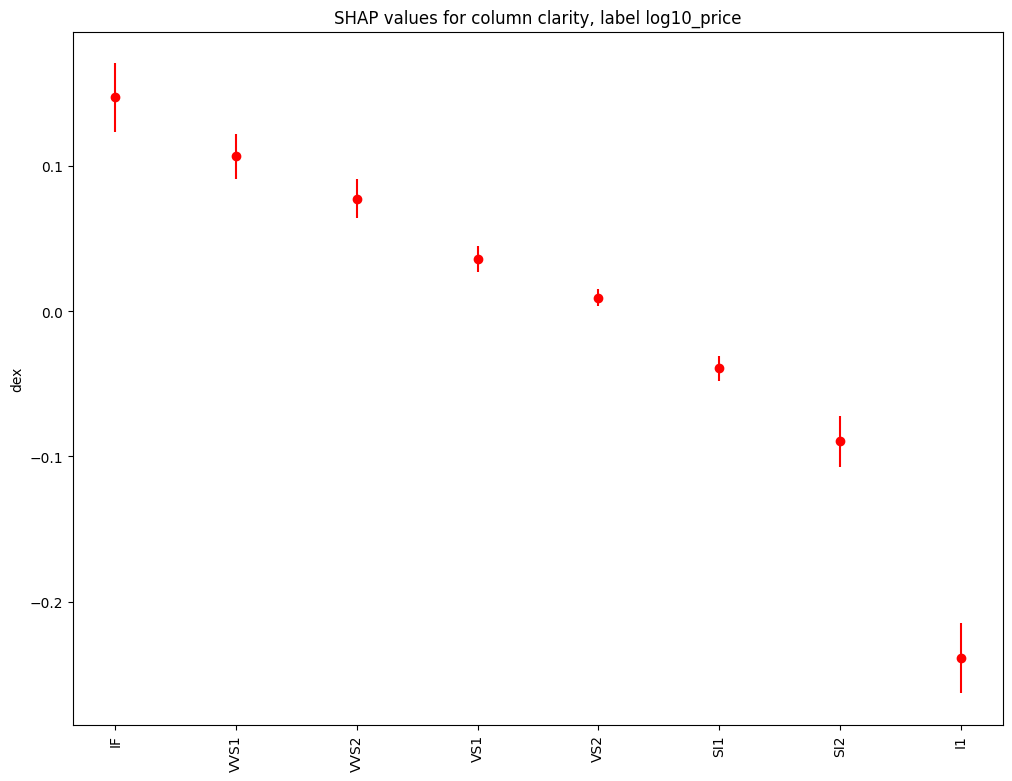

        gain  gain_std  count
col                          
IF    0.1474    0.0236    900
VVS1  0.1067    0.0152   1884
VVS2  0.0775    0.0134   2532
VS1   0.0360    0.0090   3940
VS2   0.0094    0.0060   6090
SI1  -0.0393    0.0088   6534
SI2  -0.0895    0.0176   4627
I1   -0.2391    0.0240    381

depth



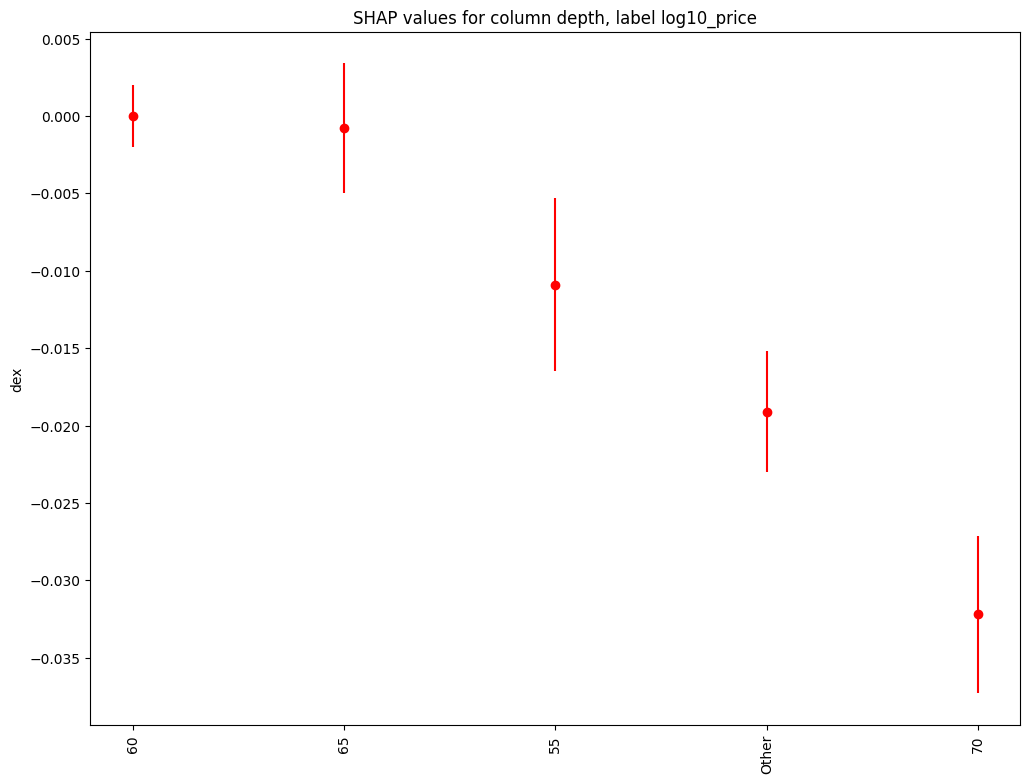

         gain  gain_std  count
col                           
60     0.0000    0.0020  20104
65    -0.0008    0.0042   6567
55    -0.0109    0.0056    154
Other -0.0191    0.0039      8
70    -0.0322    0.0051     55

table



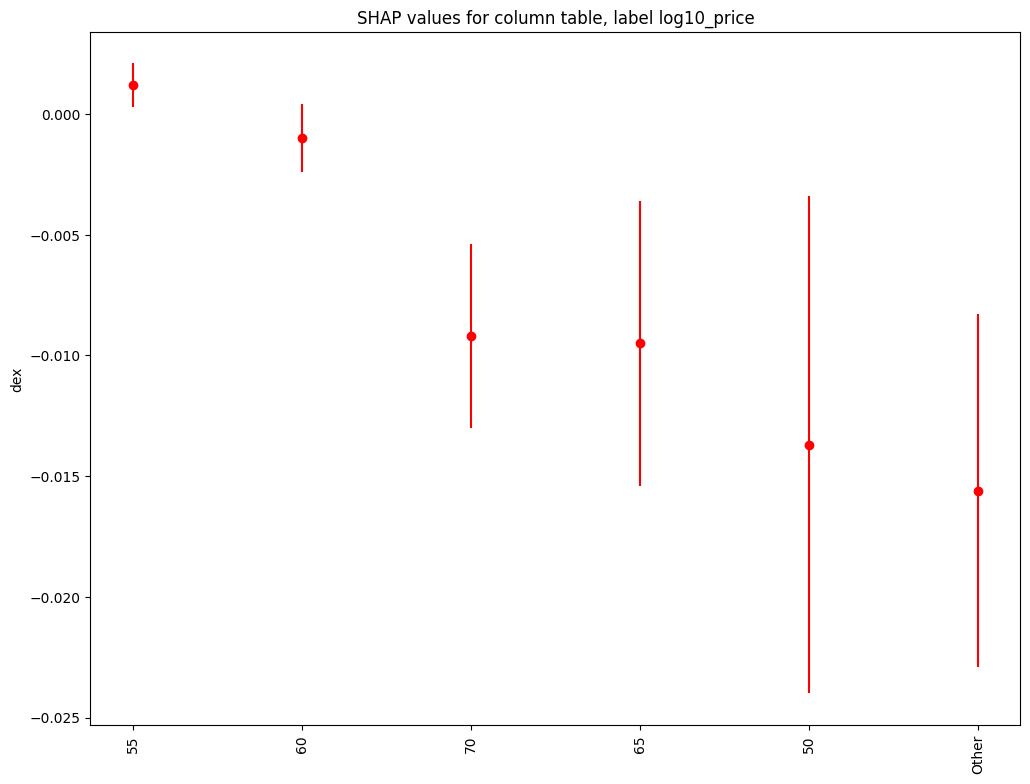

         gain  gain_std  count
col                           
55     0.0012    0.0009  14807
60    -0.0010    0.0014  11461
70    -0.0092    0.0038     21
65    -0.0095    0.0059    552
50    -0.0137    0.0103     41
Other -0.0156    0.0073      6

log10_carat



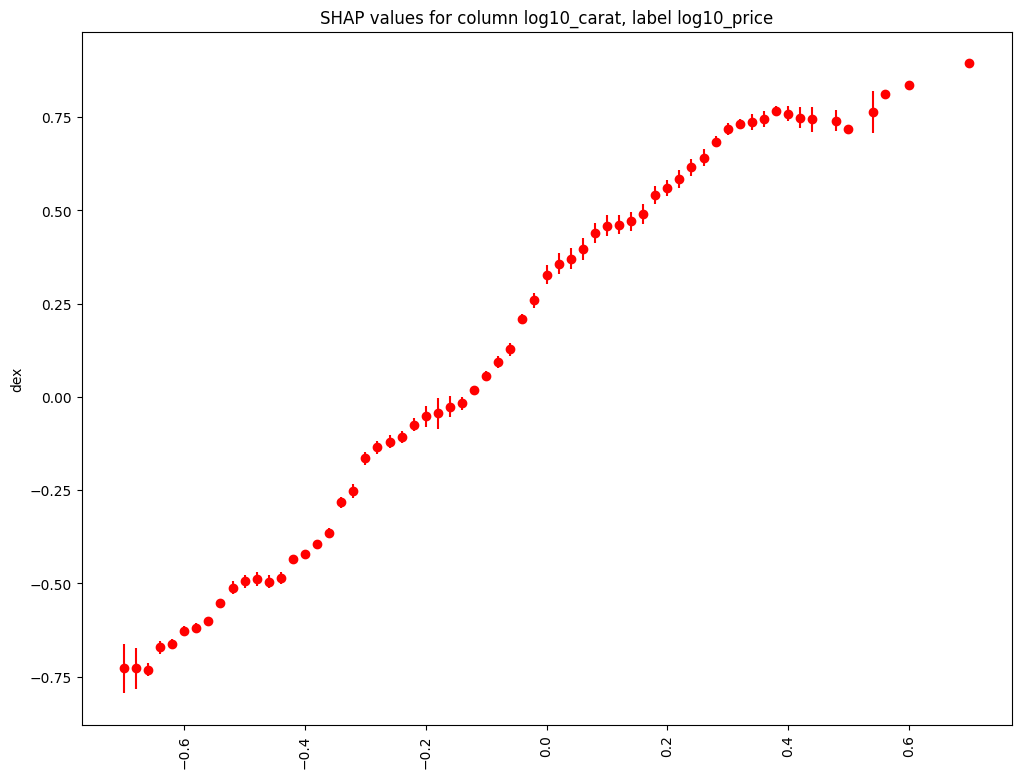

         gain  gain_std  count
col                           
 0.70  0.8950       NaN      1
 0.60  0.8355       NaN      1
 0.56  0.8124       NaN      1
 0.38  0.7666    0.0144     46
 0.54  0.7646    0.0564      2
 0.40  0.7598    0.0195     44
 0.42  0.7492    0.0278      8
 0.36  0.7450    0.0220     77
 0.44  0.7444    0.0333      9
 0.48  0.7403    0.0278     10
 0.34  0.7372    0.0205    138
 0.32  0.7328    0.0129    192
 0.50  0.7195    0.0054      2
 0.30  0.7190    0.0164    557
 0.28  0.6839    0.0149     24
 0.26  0.6409    0.0229     49
 0.24  0.6159    0.0224    283
 0.22  0.5846    0.0241    121
 0.20  0.5610    0.0212    376
 0.18  0.5404    0.0244   1167
 0.16  0.4909    0.0275     59
 0.14  0.4708    0.0249    169
 0.12  0.4617    0.0254    316
 0.10  0.4596    0.0287    439
 0.08  0.4397    0.0278    971
 0.06  0.3973    0.0296    438
 0.04  0.3709    0.0276    656
 0.02  0.3570    0.0278   1042
 0.00  0.3274    0.0254   2340
-0.02  0.2586    0.0213    150
-0.04  0

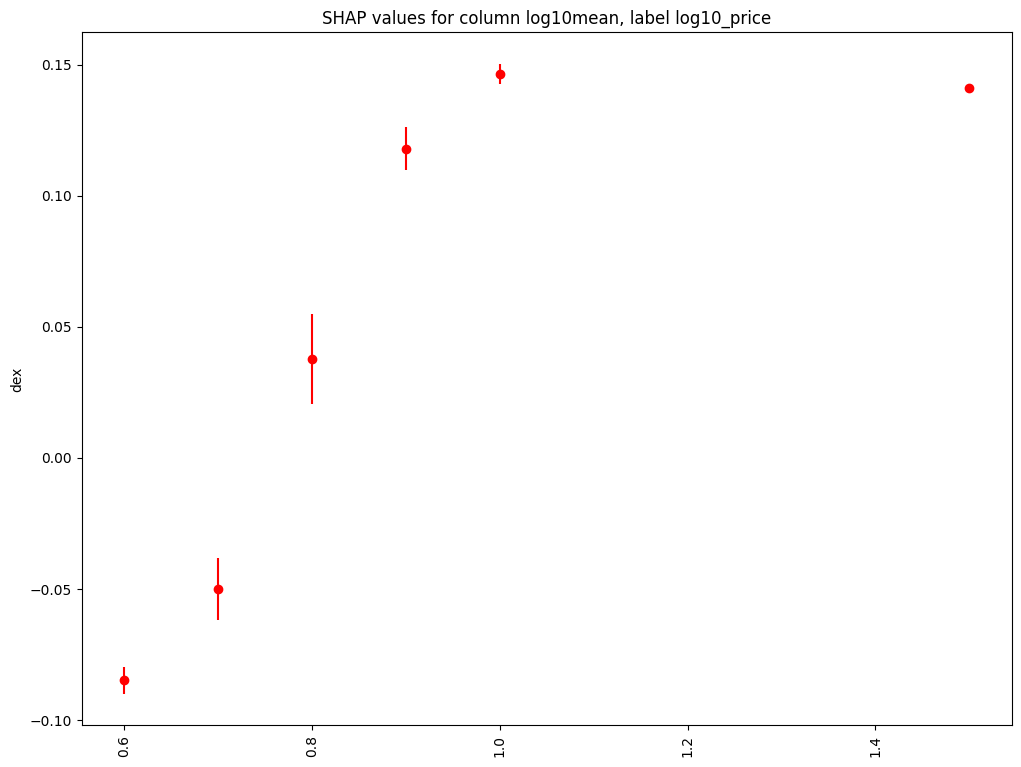

       gain  gain_std  count
col                         
1.0  0.1465    0.0039     23
1.5  0.1411       NaN      1
0.9  0.1180    0.0081   3334
0.8  0.0377    0.0172  10792
0.7 -0.0500    0.0117   8080
0.6 -0.0849    0.0051   4658


In [ ]:
def show_shap(col, shap_values=shap_values, label=main_label, X_test=X_test, ylabel='dex'):
    df_infl = X_test.copy()
    df_infl['shap_'] = shap_values[:,df_infl.columns.tolist().index(col)]
    gain = round(df_infl.groupby(col).mean()['shap_'],4)
    gain_std = round(df_infl.groupby(col).std()['shap_'],4)
    cnt = df_infl.groupby(col).count()['shap_']
    dd_dict = {'col': list(gain.index), 'gain': list(gain.values), 'gain_std': list(gain_std.values), 'count': cnt}
    df_res = pd.DataFrame.from_dict(dd_dict).sort_values('gain', ascending=False).set_index('col')
    plt.figure(figsize=(12,9))
    plt.errorbar(df_res.index, df_res['gain'], yerr=df_res['gain_std'], fmt="o", color="r")
    plt.title(f'SHAP values for column {col}, label {label}')
    plt.ylabel(ylabel)
    plt.tick_params(axis="x", rotation=90)
    plt.show();
    print(df_res)
    return

for col in X_test.columns:
    print()
    print(col)
    print()
    show_shap(col, shap_values, label=main_label, X_test=X_test)